# Pronóstico de series de tiempo con Prophet vs SARIMA

Este notebook tiene como objetivo comparar dos modelos de series de tiempo para predecir los ingresos mensuales (`Revenue`) y seleccionar el más adecuado para la planificación estratégica.

## Fase 0: Construir y entender la pregunta de negocio
**¿Qué queremos resolver?**

Queremos predecir los ingresos mensuales futuros para la empresa con base en el comportamiento histórico. Esto permitirá tomar decisiones informadas en proyecciones de ventas, inventario y crecimiento.

**Objetivo:** Evaluar dos métodos de predicción — Prophet y SARIMA — para determinar cuál ofrece mayor precisión y menor error en las predicciones.

## Fase 1: Entendimiento de los datos
Descripción de las columnas del dataset:
- `Period`: Fecha en formato mensual.
- `Revenue`: Ingresos totales del mes (variable a predecir).
- `Sales_quantity`: Cantidad de productos vendidos.
- `Average_cost`: Costo promedio por producto.
- `The_average_annual_payroll_of_the_region`: Nómina promedio anual de la región.

In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\EQUIPO\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## Fase 2: Importar y preparar la base de datos
En esta fase cargamos la base de datos, convertimos la columna `Period` a formato datetime y eliminamos datos duplicados o faltantes.

In [4]:
# importar dataset
df = pd.read_csv('Month_Value_1.csv')
# Preparar la columna fecha
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
# Ordenar el dataframe por fecha
df = df.sort_values('Period')
# Eliminar duplicados y valores nulos
df = df.drop_duplicates()
df = df.dropna()
# Mostrar las primeras filas del dataframe
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-02-01,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-03-01,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-04-01,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-05-01,1.402148e+07,8620.0,1626.621765,30024676.0


## Fase 3: Análisis Exploratorio de Datos (EDA)
Analizamos la distribución de los ingresos, su evolución a lo largo del tiempo y la relación entre variables numéricas mediante un mapa de calor de correlaciones.

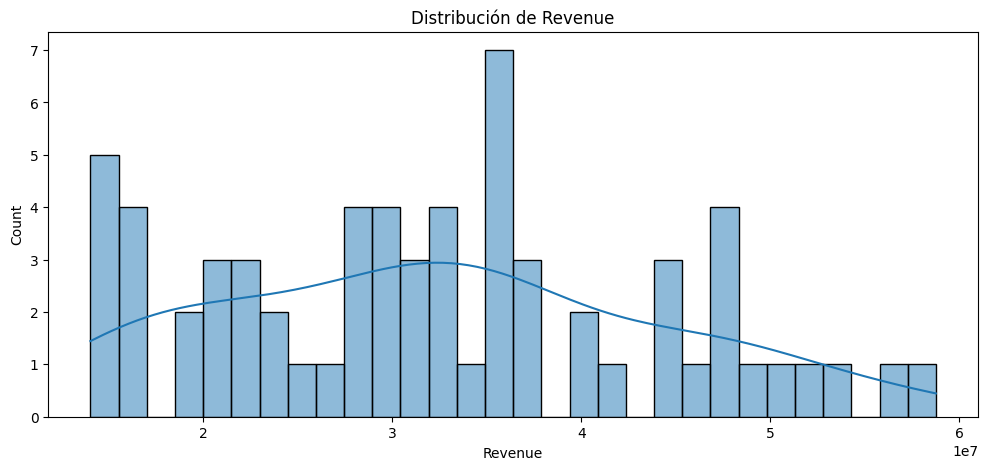

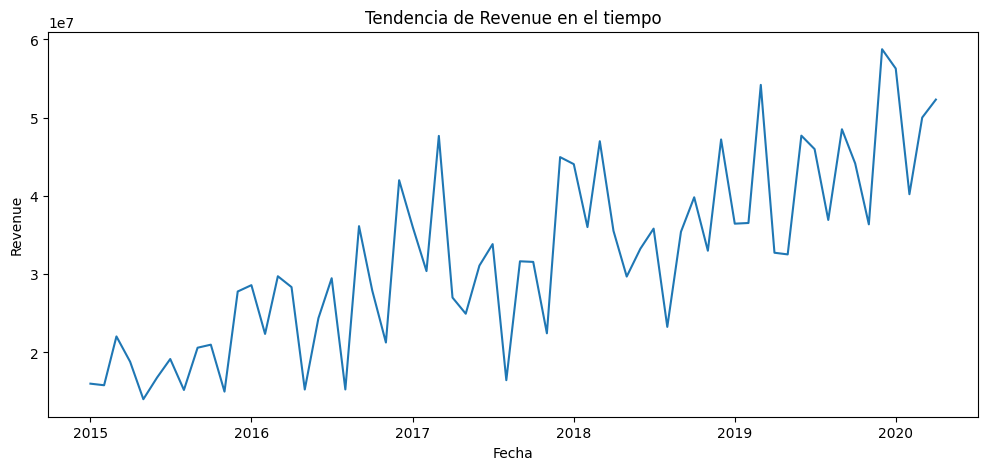

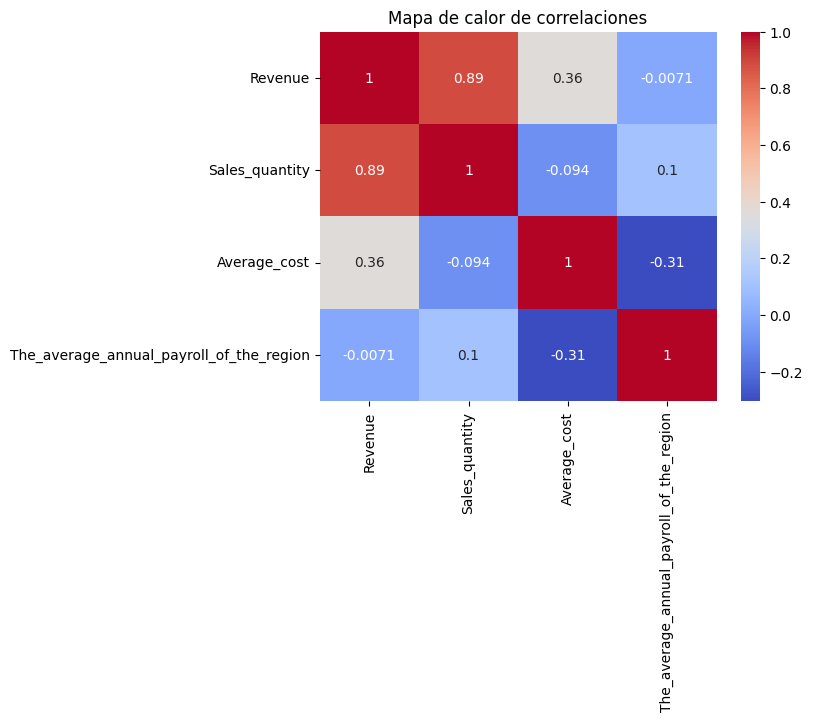

In [5]:
plt.figure(figsize=(12,5))
sns.histplot(df['Revenue'], bins=30, kde=True)
plt.title('Distribución de Revenue')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df['Period'], df['Revenue'])
plt.title('Tendencia de Revenue en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Revenue')
plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

**Interpretación del EDA:**
- El gráfico de líneas muestra una tendencia general de los ingresos.
- El histograma permite detectar asimetrías y posibles outliers.
- La matriz de correlación nos ayuda a identificar variables relacionadas con `Revenue` como `Sales_quantity`.

## Fase 4: Preparación de datos para modelamiento
Dividimos los datos en entrenamiento y prueba. Usaremos los últimos 6 meses para evaluar los modelos.

In [6]:
df_prophet = df[['Period', 'Revenue']].rename(columns={'Period': 'ds', 'Revenue': 'y'})
train = df_prophet.iloc[:-6]
test = df_prophet.iloc[-6:]

## Fase 5: Modelo 1 con Prophet
Prophet es un modelo desarrollado por Facebook que se adapta bien a series con estacionalidad y tendencia. Aquí ajustamos el modelo y generamos predicciones.

08:48:28 - cmdstanpy - INFO - Chain [1] start processing
08:48:28 - cmdstanpy - INFO - Chain [1] done processing


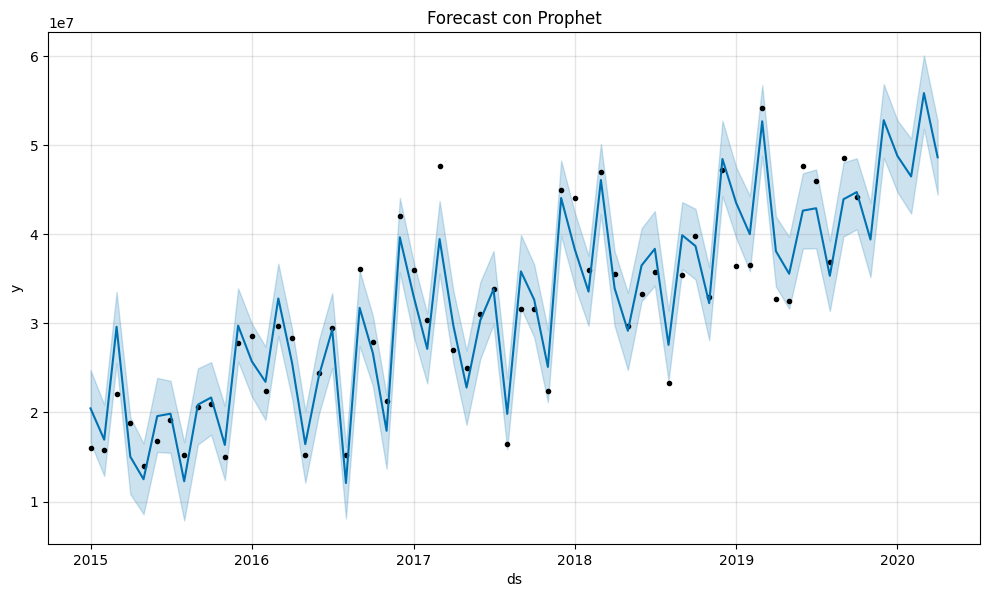

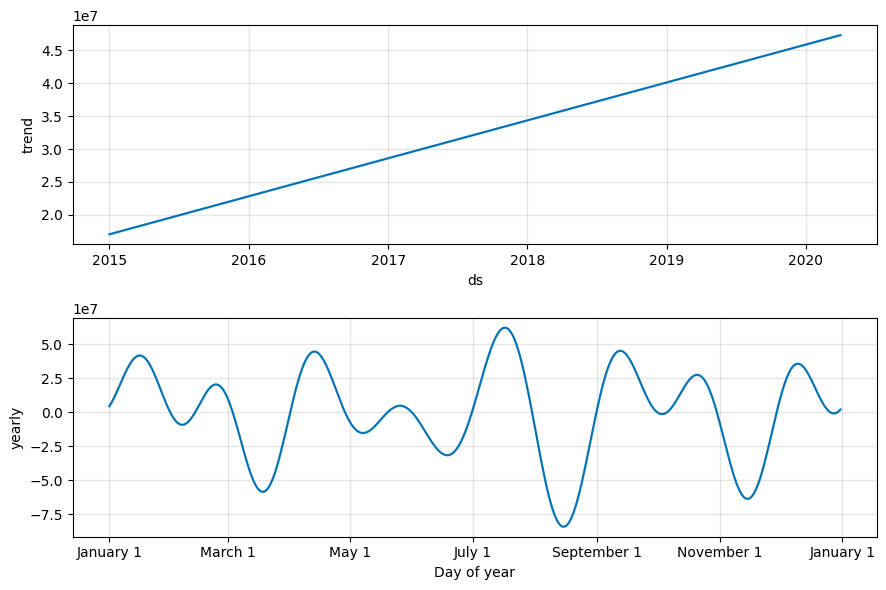

In [7]:
model_prophet = Prophet()
model_prophet.fit(train)
future = model_prophet.make_future_dataframe(periods=6, freq='MS')
forecast_prophet = model_prophet.predict(future)

model_prophet.plot(forecast_prophet)
plt.title('Forecast con Prophet')
plt.show()

model_prophet.plot_components(forecast_prophet)
plt.show()

**Interpretación del modelo Prophet:**
- El gráfico muestra la predicción futura con un intervalo de confianza.
- Los componentes permiten ver tendencia y estacionalidad anual o mensual si existe.

## Fase 6: Modelo 2 con SARIMA
SARIMA extiende ARIMA incorporando efectos estacionales. Ajustamos y graficamos sus predicciones.

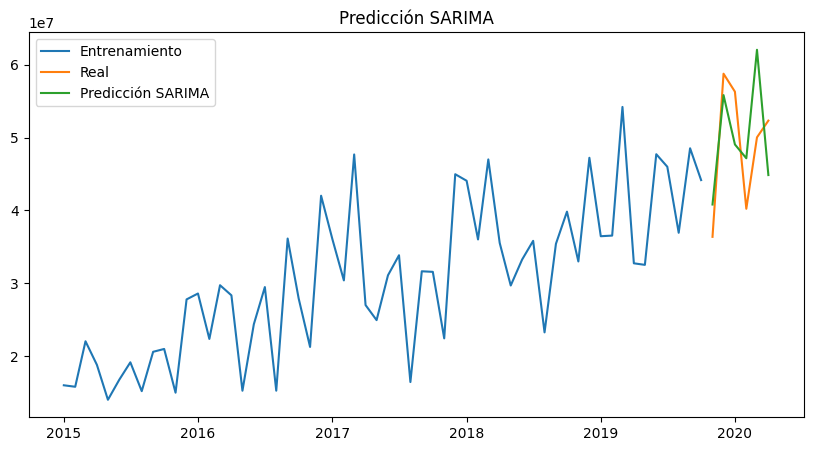

In [8]:
train_sarima = df.set_index('Period')['Revenue'][:-6]
test_sarima = df.set_index('Period')['Revenue'][-6:]

model_sarima = SARIMAX(train_sarima, order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=6)

plt.figure(figsize=(10,5))
plt.plot(train_sarima.index, train_sarima, label='Entrenamiento')
plt.plot(test_sarima.index, test_sarima, label='Real')
plt.plot(test_sarima.index, forecast_sarima, label='Predicción SARIMA')
plt.title('Predicción SARIMA')
plt.legend()
plt.show()

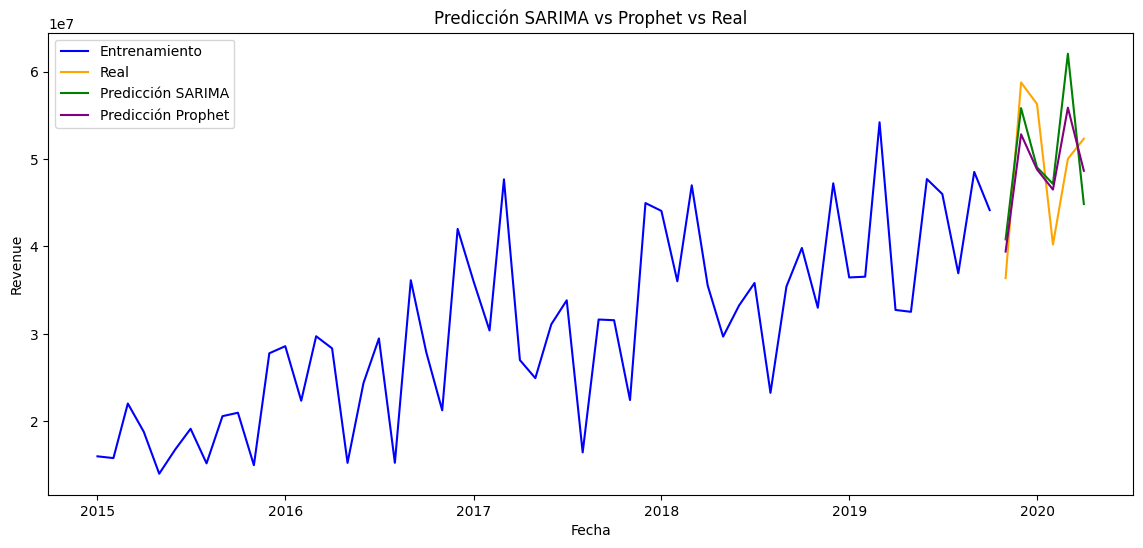

In [20]:
plt.figure(figsize=(14,6))

# Entrenamiento
plt.plot(train_sarima.index, train_sarima, label='Entrenamiento', color='blue')

# Real
plt.plot(test_sarima.index, test_sarima, label='Real', color='orange')

# SARIMA
plt.plot(test_sarima.index, forecast_sarima, label='Predicción SARIMA', color='green')

# Prophet (usamos 'ds' del test porque Prophet trabaja con DataFrame separado)
plt.plot(test['ds'], y_pred_prophet, label='Predicción Prophet', color='purple')

plt.title("Predicción SARIMA vs Prophet vs Real")
plt.xlabel("Fecha")
plt.ylabel("Revenue")
plt.legend()
plt.show()


**Interpretación del modelo SARIMA:**
- Compara las predicciones con los datos reales del período de prueba.
- Se observa qué tan bien el modelo captura la estacionalidad o fluctuaciones mensuales.

## Fase 7: Evaluación de modelos
Utilizamos MAE y RMSE para evaluar la precisión. Cuanto menores sean estas métricas, mejor es el modelo.

In [11]:
y_true = test['y'].values
y_pred_prophet = forecast_prophet.iloc[-6:]['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))


mae_sarima = mean_absolute_error(test_sarima, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test_sarima, forecast_sarima))


print(f'Prophet -> MAE: {mae_prophet}, RMSE: {rmse_prophet}')
print(f'SARIMA -> MAE: {mae_sarima}, RMSE: {rmse_sarima}')

Prophet -> MAE: 5374521.336585328, RMSE: 5589383.408303508
SARIMA -> MAE: 6838231.440081547, RMSE: 7404281.334064884


**Interpretación de métricas:**
- MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos. Cuanto más bajo, mejor.

- RMSE (Root Mean Squared Error): penaliza más los errores grandes que el MAE. También se busca que sea lo más bajo posible.

| Modelo      | MAE (Error Absoluto Medio) | RMSE (Raíz del Error Cuadrático Medio) |
| ----------- | -------------------------- | -------------------------------------- |
| **Prophet** | 5,374,521                  | 5,589,383                              |
| **SARIMA**  | 6,838,231                  | 7,404,281                              |


El modelo Prophet es el que mejor se comportó en este caso, ya que:

- Tiene menor MAE → predice con menor error promedio.

- Tiene menor RMSE → sus errores grandes son más bajos que los del modelo SARIMA.

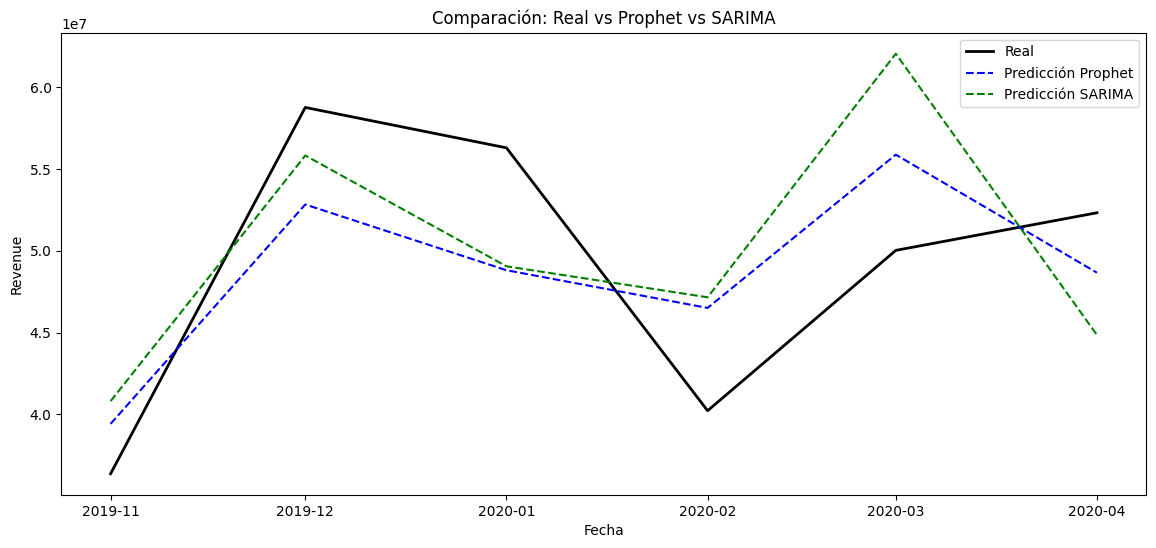

In [14]:
plt.figure(figsize=(14,6))
plt.plot(test['ds'], test['y'], label='Real', color='black', linewidth=2)
plt.plot(test['ds'], y_pred_prophet, label='Predicción Prophet', color='blue', linestyle='--')
plt.plot(test['ds'], forecast_sarima.values, label='Predicción SARIMA', color='green', linestyle='--')
plt.title('Comparación: Real vs Prophet vs SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Revenue')
plt.legend()
plt.show()

## Fase 8: Mejora del modelo - Limpieza de Outliers
Aplicamos el método del rango intercuartílico para remover valores atípicos que puedan afectar los modelos.

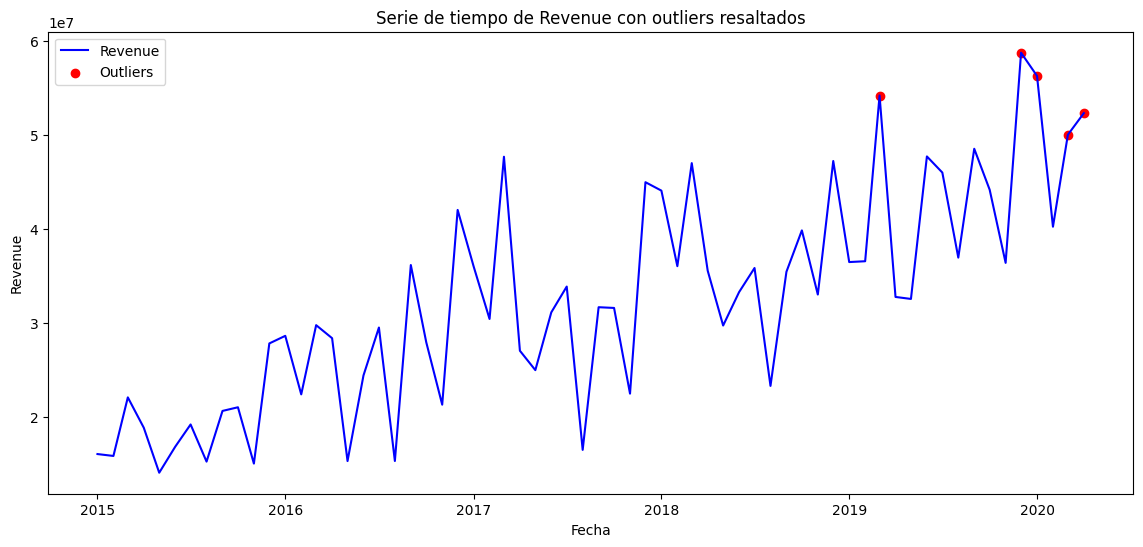

In [17]:
# q1 = df['Revenue'].quantile(0.05)
# q3 = df['Revenue'].quantile(0.95)
# iqr = q3 - q1
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

upper_bound = 5.0e7  # ejemplo: 50 millones
lower_bound = 1.0e7  # ejemplo: 10 millones


# Identificamos outliers
df['is_outlier'] = (df['Revenue'] < lower_bound) | (df['Revenue'] > upper_bound)

# Gráfico
plt.figure(figsize=(14,6))
plt.plot(df['Period'], df['Revenue'], label='Revenue', color='blue')
plt.scatter(df[df['is_outlier']]['Period'], df[df['is_outlier']]['Revenue'], color='red', label='Outliers')
plt.title('Serie de tiempo de Revenue con outliers resaltados')
plt.xlabel('Fecha')
plt.ylabel('Revenue')
plt.legend()
plt.show()
# Guardar el dataframe con outliers
#df.to_csv('Month_Value_1_with_outliers.csv', index=False)


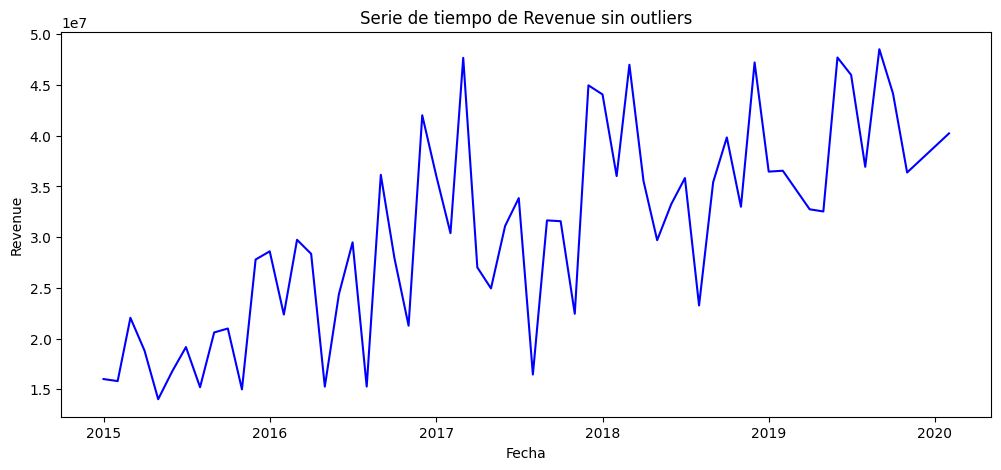

In [18]:
# q1 = df['Revenue'].quantile(0.25)
# q3 = df['Revenue'].quantile(0.75)
# iqr = q3 - q1
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr


upper_bound = 5.0e7  # ejemplo: 50 millones
lower_bound = 1.0e7  # ejemplo: 10 millones


df_cleaned = df[(df['Revenue'] >= lower_bound) & (df['Revenue'] <= upper_bound)]

# graficar el dataset limpio de outliers
plt.figure(figsize=(12,5))
plt.plot(df_cleaned['Period'], df_cleaned['Revenue'], color='blue')
plt.title('Serie de tiempo de Revenue sin outliers')
plt.xlabel('Fecha')
plt.ylabel('Revenue')
plt.show()

## Fase 9: DataFrame final con predicciones
Creamos un DataFrame que contiene los valores reales y predichos por ambos modelos.

In [19]:
df_result = test.copy()
df_result['Prophet_Pred'] = y_pred_prophet
df_result['SARIMA_Pred'] = forecast_sarima.values
df_result

,ds,y,Prophet_Pred,SARIMA_Pred
58,2019-11-01,3.637496e+07,3.942101e+07,4.081056e+07
59,2019-12-01,5.875647e+07,5.282648e+07,5.581868e+07
60,2020-01-01,5.628830e+07,4.880986e+07,4.904880e+07
61,2020-02-01,4.022524e+07,4.650625e+07,4.715524e+07
62,2020-03-01,5.002217e+07,5.587120e+07,6.203897e+07
63,2020-04-01,5.232069e+07,4.865809e+07,4.485100e+07


## Fase 10: Exportar DataFrame con resultados

In [ ]:
df_result.to_csv('Revenue_Forecast_Comparison.csv', index=False)